<a href="https://colab.research.google.com/github/ansonmiu0214/SessionTS-Benchmarks/blob/master/SessionTS_Benchmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SessionTS Benchmarks

To analyse performance bottleneck in session runtimes 
for Node and React endpoints.

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

In [2]:
import os
import shutil

REPO_PATH = '/content/SessionTS-Benchmarks'
if os.path.exists(REPO_PATH):
    print('Note: deleting stale repo')
    shutil.rmtree(REPO_PATH)

!git clone https://github.com/ansonmiu0214/SessionTS-Benchmarks.git
assert os.path.exists(REPO_PATH)

Cloning into 'SessionTS-Benchmarks'...
remote: Enumerating objects: 934, done.
remote: Counting objects: 100% (934/934), done.
remote: Compressing objects: 100% (686/686), done.
remote: Total 934 (delta 318), reused 825 (delta 242), pack-reused 0
Receiving objects: 100% (934/934), 10.82 MiB | 18.38 MiB/s, done.
Resolving deltas: 100% (318/318), done.


## Helper Functions

In [3]:
import typing

def average(xs):
    """Compute average of a list."""

    return float(sum(xs)) / float(len(xs))

def from_ms(ms):
    """Parse numerical millisecond value from string suffixed with 'ms."""

    if not ms.endswith('ms'):
        raise Exception(f'Cannot parse millisecond value from: {ms}')
    return float(ms[:-2])

def parse_pingpong(line):
    _, time = line.split(' ')
    return from_ms(time)

def parse_console_timestamp(line):
    _, time, _ = line.split(' ')
    return from_ms(time)

def parse_total(line):
    _, time = line.split(' ')
    return from_ms(time)

def rolling_average(xs, interval=10):
    acc = sum(xs[:(interval - 1)])
    rolling_avg = [None for _ in range(interval - 1)]

    i = 0
    for item in xs[(interval-1):]:
        acc += item
        rolling_avg.append(acc / interval)
        acc -= xs[i]
        i += 1
    
    return rolling_avg

## Data Loader

In [4]:
from collections import namedtuple

Log = namedtuple('Log',
                 ('benchmark_times', 'benchmark_total', 'message_times'))

class BenchmarkInstance:

    def __init__(self, *, 
                 variant,
                 num_msgs,
                 node_logs: typing.List[Log],
                 react_logs: typing.List[Log]):
        self.variant = variant
        self.num_msgs = num_msgs
        self._node_logs = node_logs
        self._react_logs = react_logs

    def _extract_log_attr(self, log_name, log_attr):
        return [getattr(log, log_attr)
                for log in getattr(self, f'_{log_name}_logs')]

    def _aggregate_average(self, log_name, log_attr):
        transposed = list(zip(*self._extract_log_attr(log_name, log_attr)))
        return [average(items) for items in transposed]

    def avg_timeline(self, endpoint):
        return self._aggregate_average(endpoint, 'message_times')

    def avg_benchmark_total(self, endpoint):
        return average(self._extract_logs(endpoint, 'benchmark_total'))

    def avg_benchmark(self, endpoint):
        return self._aggregate_average(endpoint, 'benchmark_times')

class BenchmarkLibrary:

    def __init__(self, instances):
        self._instances = instances

    def get(self, *, variant, num_msgs):
        result = [instance for instance in self._instances
                  if instance.variant == variant and instance.num_msgs == num_msgs]
        if not result:
            raise Exception(f'Cannot find log: {variant}, {num_msgs}')
        return result[0]

    def get_multiple(self, *, variant=None, num_msgs=None):
        if variant is not None:
            return [instance for instance in self._instances
                    if instance.variant == variant]
        if num_msgs is not None:
            return [instance for instance in self._instances
                    if instance.num_msgs == num_msgs]
        return []

In [5]:
def parse_node_log(log):
    lines = [line.strip() for line in log.split('\n') if line.strip()]

    # Get benchmark timestamps
    benchmark_times = [line for line in lines if line.startswith('benchmark:')]
    benchmark_timestamps = [parse_console_timestamp(line)
                            for line in benchmark_times[:-1]]
    benchmark_total = parse_total(benchmark_times[-1])

    # Get pingpong timestamps
    pingpong_timestamps = [parse_pingpong(line)
                           for line in lines if line.startswith('pingpong')]

    return benchmark_times, benchmark_total, pingpong_timestamps

def parse_react_log(log):
    lines = [' '.join(line.strip().split(' ')[1:])
             for line in log.split('\n') if line.strip()]

    # Get benchmark timestamps
    benchmark_times = [line for line in lines if line.startswith('benchmark:')]
    benchmark_timestamps = [parse_console_timestamp(line)
                            for line in benchmark_times[:-1]]
    benchmark_total = parse_total(benchmark_times[-1])

    # Get pingpong timestamps
    pingpong_timestamps = [parse_pingpong(line)
                           for line in lines if line.startswith('pongping')]

    return benchmark_times, benchmark_total, pingpong_timestamps[:len(benchmark_timestamps)]

In [6]:
def accumulate_logs(*, path, variant, num_msgs):

    node_path = os.path.join(path, variant, 'server', 'finelogs')
    node_log_filenames = [os.path.join(node_path, path) 
                          for path in os.listdir(node_path)
                          if int(path.split('_')[0]) == num_msgs]

    react_path = os.path.join(path, variant, 'client', 'finelogs')
    react_log_filenames = [os.path.join(react_path, path) 
                          for path in os.listdir(react_path)
                          if int(path.split('_')[0]) == num_msgs]

    node_logs = []
    react_logs = []

    for node_log, react_log in zip(node_log_filenames, react_log_filenames):
        with open(node_log, 'r') as node_file:
            node_logs.append(Log(*parse_node_log(node_file.read())))

        with open(react_log, 'r') as react_file:
            react_logs.append(Log(*parse_react_log(react_file.read())))

    return BenchmarkInstance(variant=variant,
                             num_msgs=num_msgs,
                             node_logs=node_logs,
                             react_logs=react_logs)

# Simple Ping Pong

* PING `<button>` to send ping.
* `<div>` to show number of pongs received.

In [7]:
VARIANTS = ('bare', 'mpst')
NUM_MSGS = (100, 1000)
ENDPOINTS = ('node', 'react')

BENCHMARK_PATH = os.path.join(REPO_PATH, 'simple_pingpong')

instances = [accumulate_logs(path=BENCHMARK_PATH,
                             variant=variant,
                             num_msgs=num_msgs)
             for variant in VARIANTS
             for num_msgs in NUM_MSGS]

library = BenchmarkLibrary(instances)

## Compare message processing times between Node and React

Time taken for each round trip is dominated by the message processing logic 
in React.

In [8]:
def plot_react_node_breakdown(library, fig, axs, *, 
                              variant,
                              num_msgs,
                              ignore_connection=False):
    log_instance = library.get(variant=variant, num_msgs=num_msgs)
    node = log_instance.avg_timeline('node')
    react = log_instance.avg_timeline('react')
    
    if ignore_connection:
        node = node[1:]
        react = react[1:]
        time_axis = np.arange(1, num_msgs)
    else:
        time_axis = np.arange(num_msgs)

    axs.stackplot(time_axis, [react, node], labels=['React', 'Node'])
    axs.set_xlabel('Number of round trips')
    axs.set_ylabel('Time (ms)')

    if ignore_connection:
        axs.set_title(f'{variant}: {num_msgs} round trips (w/o connection)')
    else:
        axs.set_title(f'{variant}: {num_msgs} round trips')

    axs.legend(loc='best')

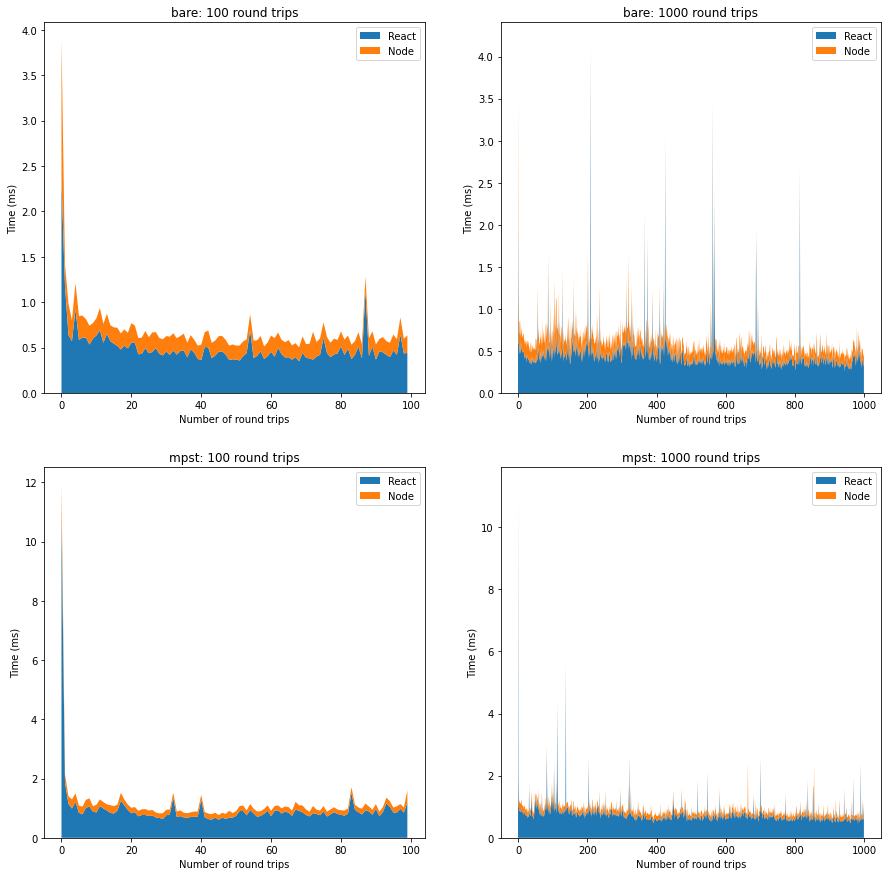

In [9]:
fig = plt.figure(figsize=(15, 15))

for i, variant in enumerate(VARIANTS):
    for j, num_msgs in enumerate(NUM_MSGS):
        idx = i * len(ENDPOINTS) + j + 1
        axs = fig.add_subplot(len(VARIANTS), len(NUM_MSGS), idx)
        plot_react_node_breakdown(library, fig, axs,
                                  variant=variant, num_msgs=num_msgs)

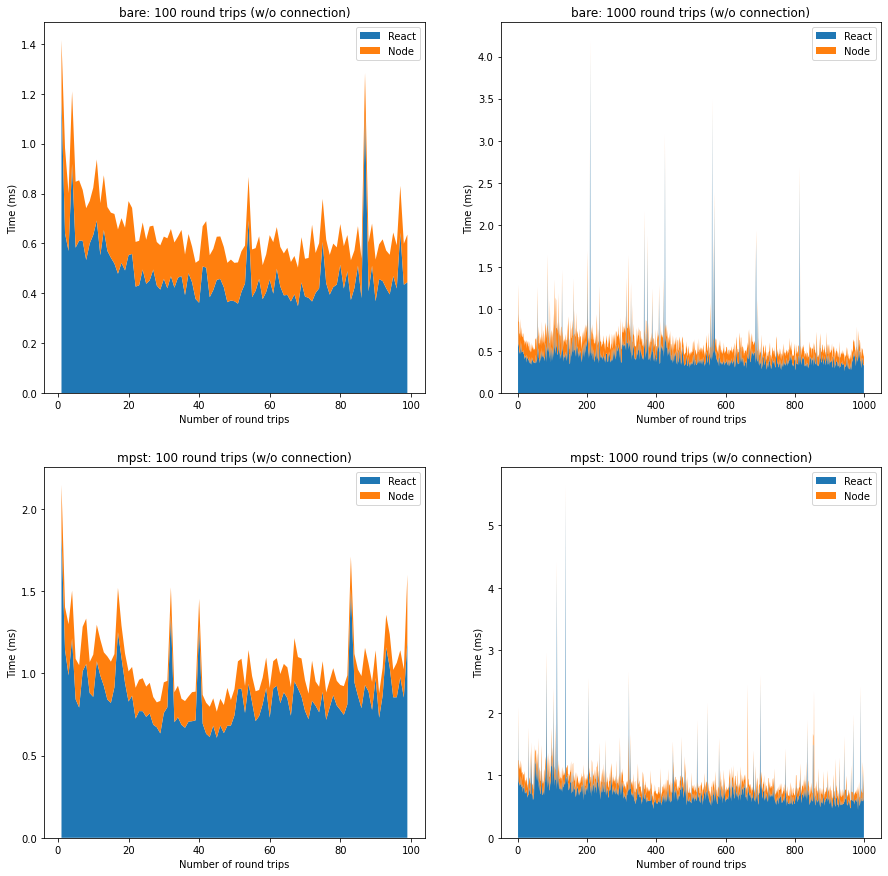

In [10]:
fig = plt.figure(figsize=(15, 15))

for i, variant in enumerate(VARIANTS):
    for j, num_msgs in enumerate(NUM_MSGS):
        idx = i * len(ENDPOINTS) + j + 1
        axs = fig.add_subplot(len(VARIANTS), len(NUM_MSGS), idx)
        plot_react_node_breakdown(library, fig, axs,
                                  variant=variant,
                                  num_msgs=num_msgs,
                                  ignore_connection=True)

## Compare overhead of MPST implementation for each endpoint

Session runtime in React incurs most of the overhead.

In [11]:
def compare_endpoint_log(library, fig, axs, *,
                         endpoint,
                         num_msgs,
                         ignore_connection=False):
    bare = library.get(variant='bare', num_msgs=num_msgs)
    mpst = library.get(variant='mpst', num_msgs=num_msgs)

    bare_times = bare.avg_timeline(endpoint)
    mpst_times = mpst.avg_timeline(endpoint)

    if ignore_connection:
        bare_times = bare_times[1:]
        mpst_times = mpst_times[1:]
        time_axis = np.arange(1, num_msgs)
    else:
        time_axis = np.arange(num_msgs)

    axs.plot(time_axis, bare_times, label=f'bare {endpoint}')
    axs.plot(time_axis, mpst_times, label=f'mpst {endpoint}')

    axs.set_xlabel('Number of round trips')
    axs.set_ylabel('Time (ms)')
    
    if ignore_connection:
        axs.set_title(f'Message processing times for {endpoint} '
                      f'through {num_msgs} round trips (w/o connection)')
    else:
        axs.set_title(f'Message processing times for {endpoint} '
                      f'through {num_msgs} round trips')
    axs.legend(loc='best')

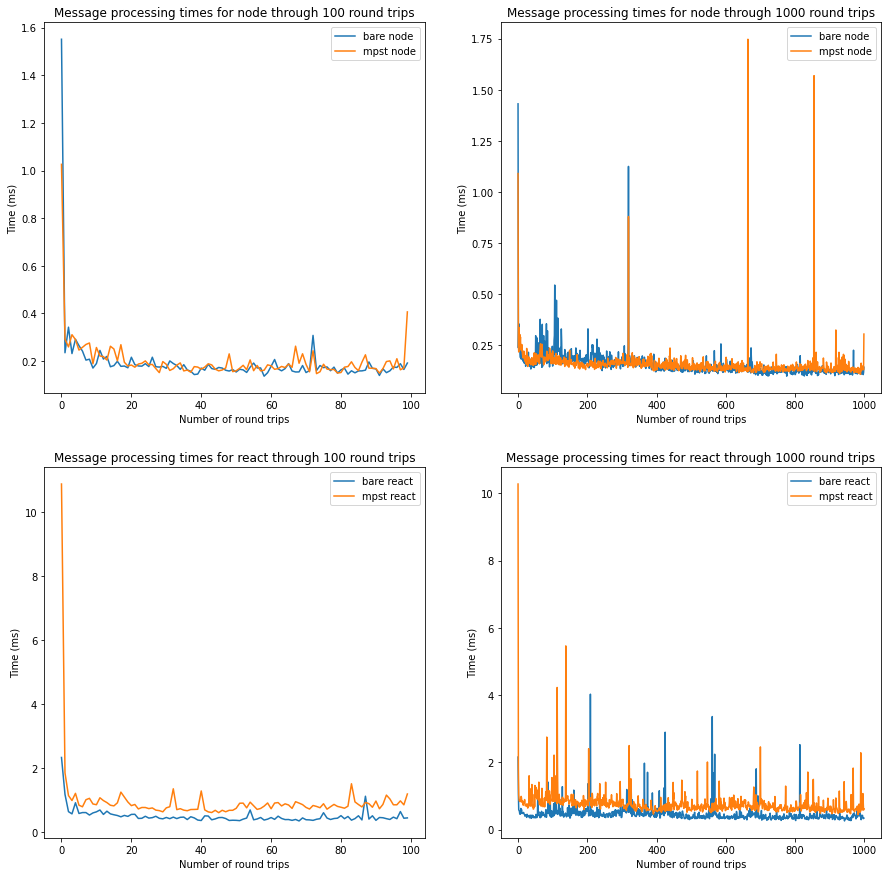

In [12]:
fig = plt.figure(figsize=(15, 15))

for i, endpoint in enumerate(ENDPOINTS):
    for j, num_msgs in enumerate(NUM_MSGS):
        idx = i * len(ENDPOINTS) + j + 1
        axs = fig.add_subplot(len(ENDPOINTS), len(NUM_MSGS), idx)
        compare_endpoint_log(library, fig, axs,
                             endpoint=endpoint,
                             num_msgs=num_msgs)

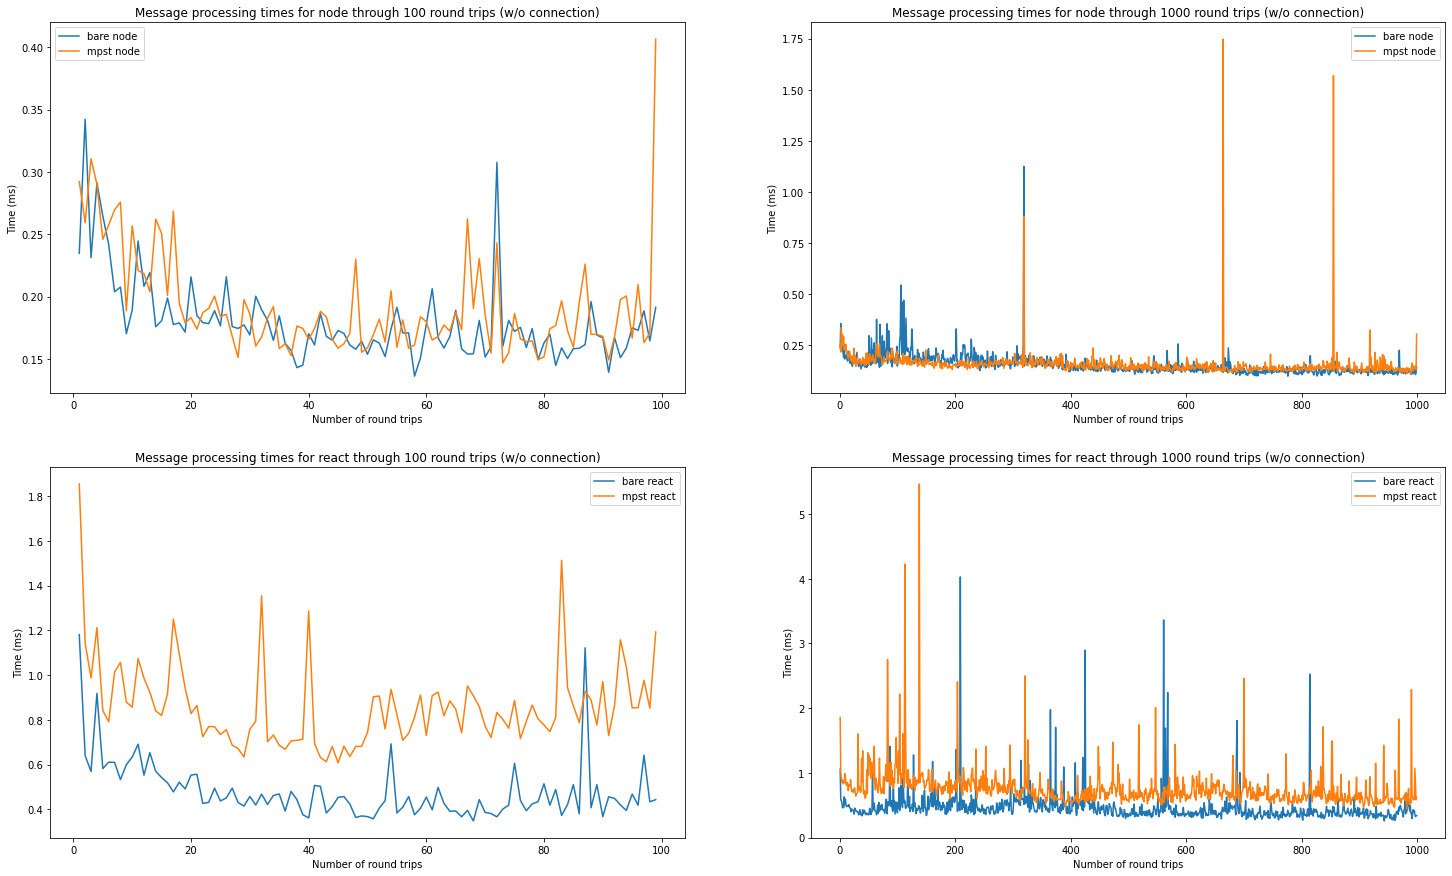

In [13]:
fig = plt.figure(figsize=(25, 15))

for i, endpoint in enumerate(ENDPOINTS):
    for j, num_msgs in enumerate(NUM_MSGS):
        idx = i * len(ENDPOINTS) + j + 1
        axs = fig.add_subplot(len(ENDPOINTS), len(NUM_MSGS), idx)
        compare_endpoint_log(library, fig, axs,
                             endpoint=endpoint,
                             num_msgs=num_msgs,
                             ignore_connection=True)

In [14]:
def compare_average_elapsed(library, *,
                            endpoint,
                            fmt='.7f',
                            ignore_connection=False):
    df = pd.DataFrame(columns=(*VARIANTS, 'delta'),
                      index=NUM_MSGS)
    
    for msg_count in NUM_MSGS:
        bare = library.get(variant='bare', num_msgs=msg_count)
        mpst = library.get(variant='mpst', num_msgs=msg_count)

        if ignore_connection:
            bare_avg = average(bare.avg_timeline(endpoint)[1:])
            mpst_avg = average(mpst.avg_timeline(endpoint)[1:])
        else:
            bare_avg = average(bare.avg_timeline(endpoint))
            mpst_avg = average(mpst.avg_timeline(endpoint))

        avgs = [format(value, fmt)
                for value in (bare_avg, mpst_avg)]
        delta = (mpst_avg - bare_avg) / bare_avg * 100
        
        df.loc[msg_count] = [*avgs, '{:.2f}%'.format(delta)]

    return df

print('Average message processing time for Node')
display(compare_average_elapsed(library, endpoint='node'))
print()

print('Average message processing time for Node (w/o connection)')
display(compare_average_elapsed(library, endpoint='node', ignore_connection=True))
print()

print('Average message processing time for React')
display(compare_average_elapsed(library, endpoint='react'))
print()

print('Average message processing time for React (w/o connection)')
display(compare_average_elapsed(library, endpoint='react', ignore_connection=True))
print()

Average message processing time for Node


,bare,mpst,delta
100,0.1937220,0.2010570,3.79%
1000,0.1537300,0.1570027,2.13%



Average message processing time for Node (w/o connection)


,bare,mpst,delta
100,0.1800071,0.1927232,7.06%
1000,0.1524514,0.1560691,2.37%



Average message processing time for React


,bare,mpst,delta
100,0.4989087,0.9613922,92.70%
1000,0.4652561,0.7659596,64.63%



Average message processing time for React (w/o connection)


,bare,mpst,delta
100,0.4803663,0.8611283,79.26%
1000,0.4635617,0.7564400,63.18%


### Aligning first 100 round trips

In [15]:
def compare_first_100_overlay(library, fig, axs, *,
                              variant,
                              endpoint,
                              ignore_connection=False):
    logs_100 = library.get(variant=variant, num_msgs=100)
    logs_1000 = library.get(variant=variant, num_msgs=1000)

    times_100 = logs_100.avg_timeline(endpoint)
    times_1000 = logs_1000.avg_timeline(endpoint)

    if ignore_connection:
        times_100 = times_100[1:]
        times_1000 = times_1000[1:100]
        time_axis = np.arange(1, 100)
    else:
        times_1000 = times_1000[:100]
        time_axis = np.arange(100)
    
    axs.plot(time_axis, times_100, label=f'{variant} {endpoint} (100)')
    axs.plot(time_axis, times_1000, label=f'{variant} {endpoint} (1000)')

    axs.set_xlabel('Number of round trips')
    axs.set_ylabel('Time (ms)')

    if ignore_connection:
        axs.set_title(f'Message processing times for {variant}_{endpoint} '
                      f'through 100 round trips (w/o connection)')
    else:
        axs.set_title(f'Message processing times for {variant}_{endpoint} '
                      f'through 100 round trips')

    axs.legend(loc='best')

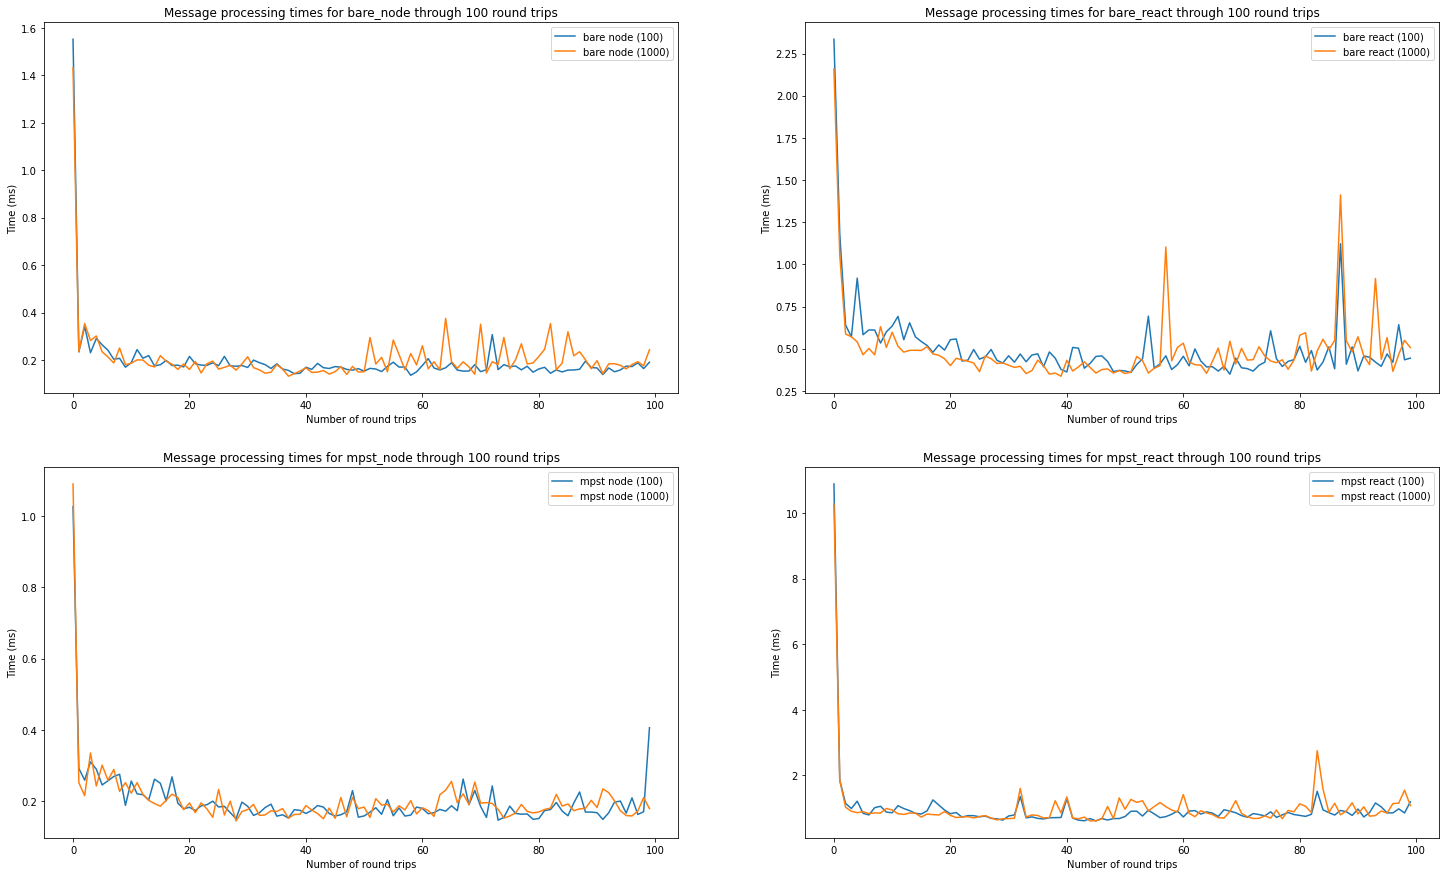

In [16]:
fig = plt.figure(figsize=(25, 15))

for i, variant in enumerate(VARIANTS):
    for j, endpoint in enumerate(ENDPOINTS):
        idx = i * len(ENDPOINTS) + j + 1
        axs = fig.add_subplot(len(VARIANTS), len(ENDPOINTS), idx)
        compare_first_100_overlay(library, fig, axs,
                                  variant=variant,
                                  endpoint=endpoint)

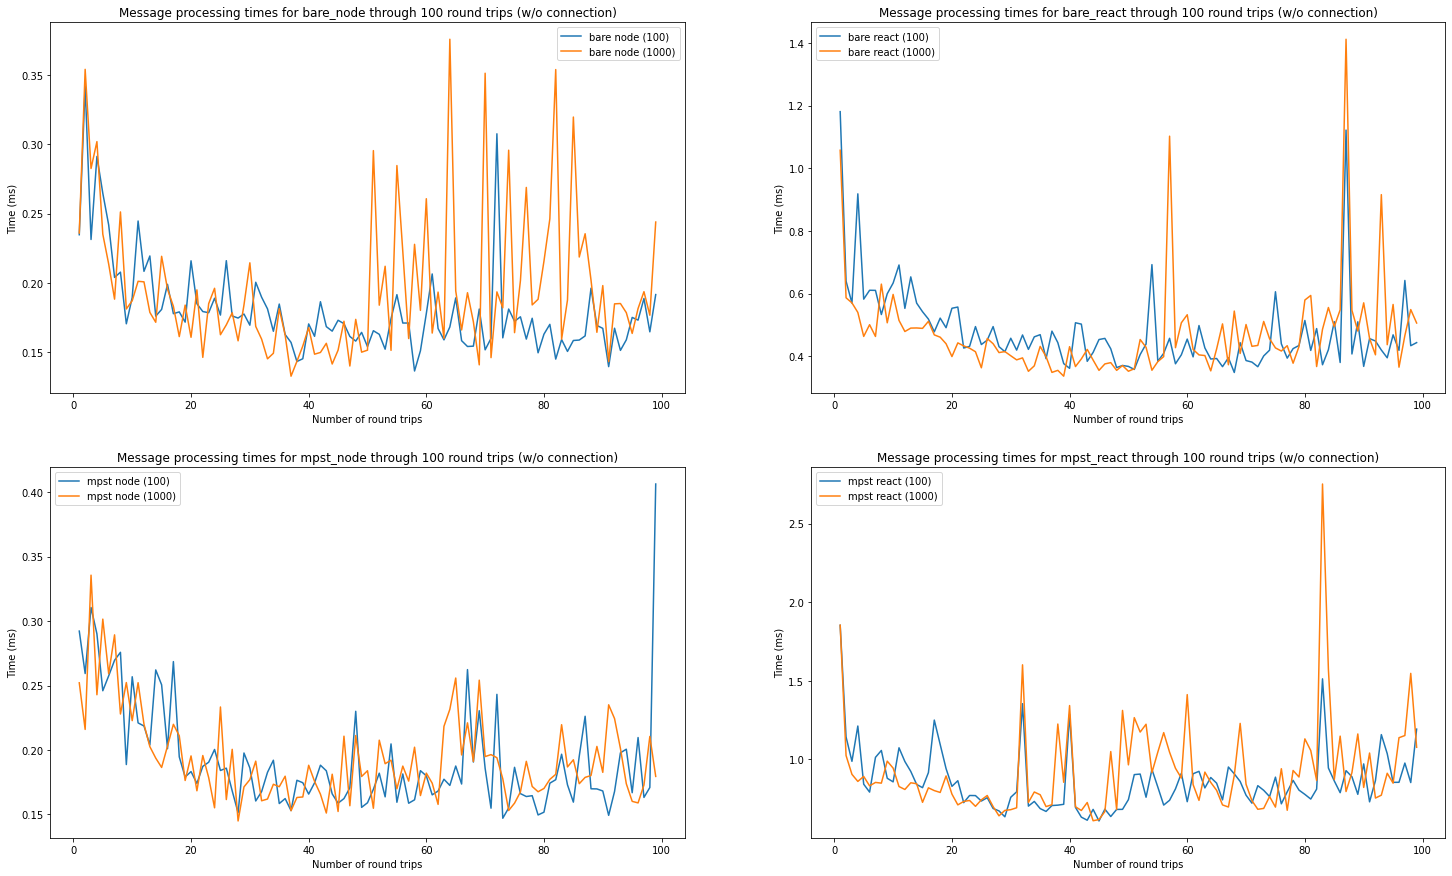

In [17]:
# Same plots, but ignoring the connection phase

fig = plt.figure(figsize=(25, 15))

for i, variant in enumerate(VARIANTS):
    for j, endpoint in enumerate(ENDPOINTS):
        idx = i * len(ENDPOINTS) + j + 1
        axs = fig.add_subplot(len(VARIANTS), len(ENDPOINTS), idx)
        compare_first_100_overlay(library, fig, axs,
                                  variant=variant,
                                  endpoint=endpoint,
                                  ignore_connection=True)

### Comparing Rollng Averages

In [18]:
def compare_rolling_avg(library, fig, axs, *,
                        endpoint,
                        num_msgs,
                        ignore_connection=False,
                        interval=10):
    bare = library.get(variant='bare', num_msgs=num_msgs)
    mpst = library.get(variant='mpst', num_msgs=num_msgs)

    bare_times = bare.avg_timeline(endpoint)
    mpst_times = mpst.avg_timeline(endpoint)

    if ignore_connection:
        bare_times = bare_times[1:]
        mpst_times = mpst_times[1:]
        time_axis = np.arange(1, num_msgs)
    else:
        time_axis = np.arange(num_msgs)

    axs.plot(time_axis, rolling_average(bare_times, interval),
             label=f'bare {endpoint}')
    axs.plot(time_axis, rolling_average(mpst_times, interval),
             label=f'mpst {endpoint}')

    axs.set_xlabel('Number of round trips')
    axs.set_ylabel('Time (ms)')
    
    if ignore_connection:
        axs.set_title(f'{interval}-rolling average message processing times '
                      f'for {endpoint} through {num_msgs} '
                      f'round trips (w/o connection)')
    else:
        axs.set_title(f'{interval}-rolling average message processing times '
                      f'for {endpoint} through {num_msgs} round trips')

    axs.legend(loc='best')

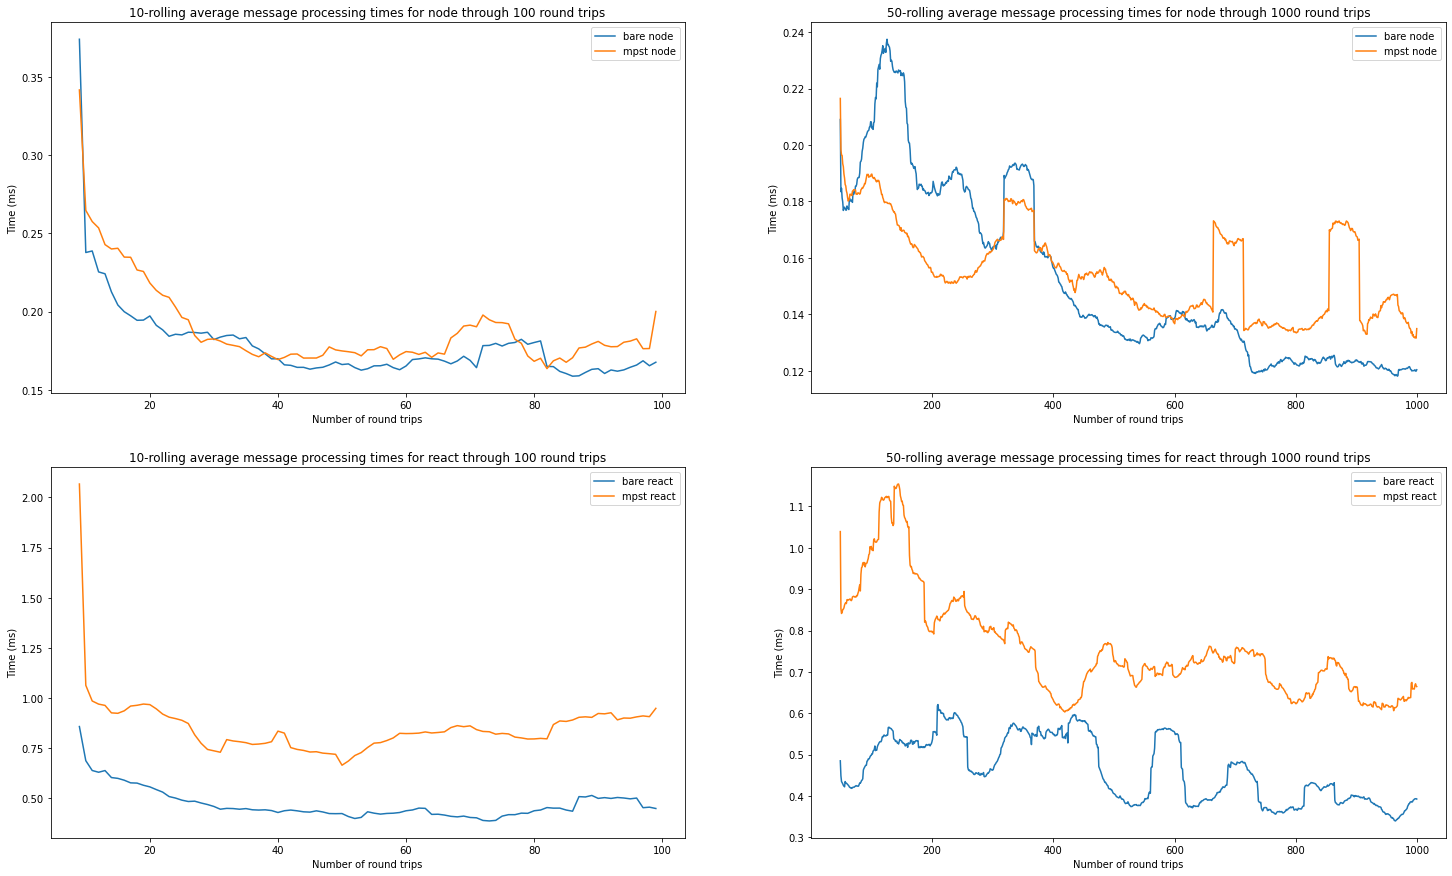

In [19]:
fig = plt.figure(figsize=(25, 15))
rolling_average_interval = {100: 10, 1000: 50}

for i, endpoint in enumerate(ENDPOINTS):
    for j, num_msgs in enumerate(NUM_MSGS):
        idx = i * len(ENDPOINTS) + j + 1
        axs = fig.add_subplot(len(ENDPOINTS), len(NUM_MSGS), idx)
        compare_rolling_avg(library, fig, axs,
                            endpoint=endpoint,
                            num_msgs=num_msgs,
                            interval=rolling_average_interval[num_msgs])

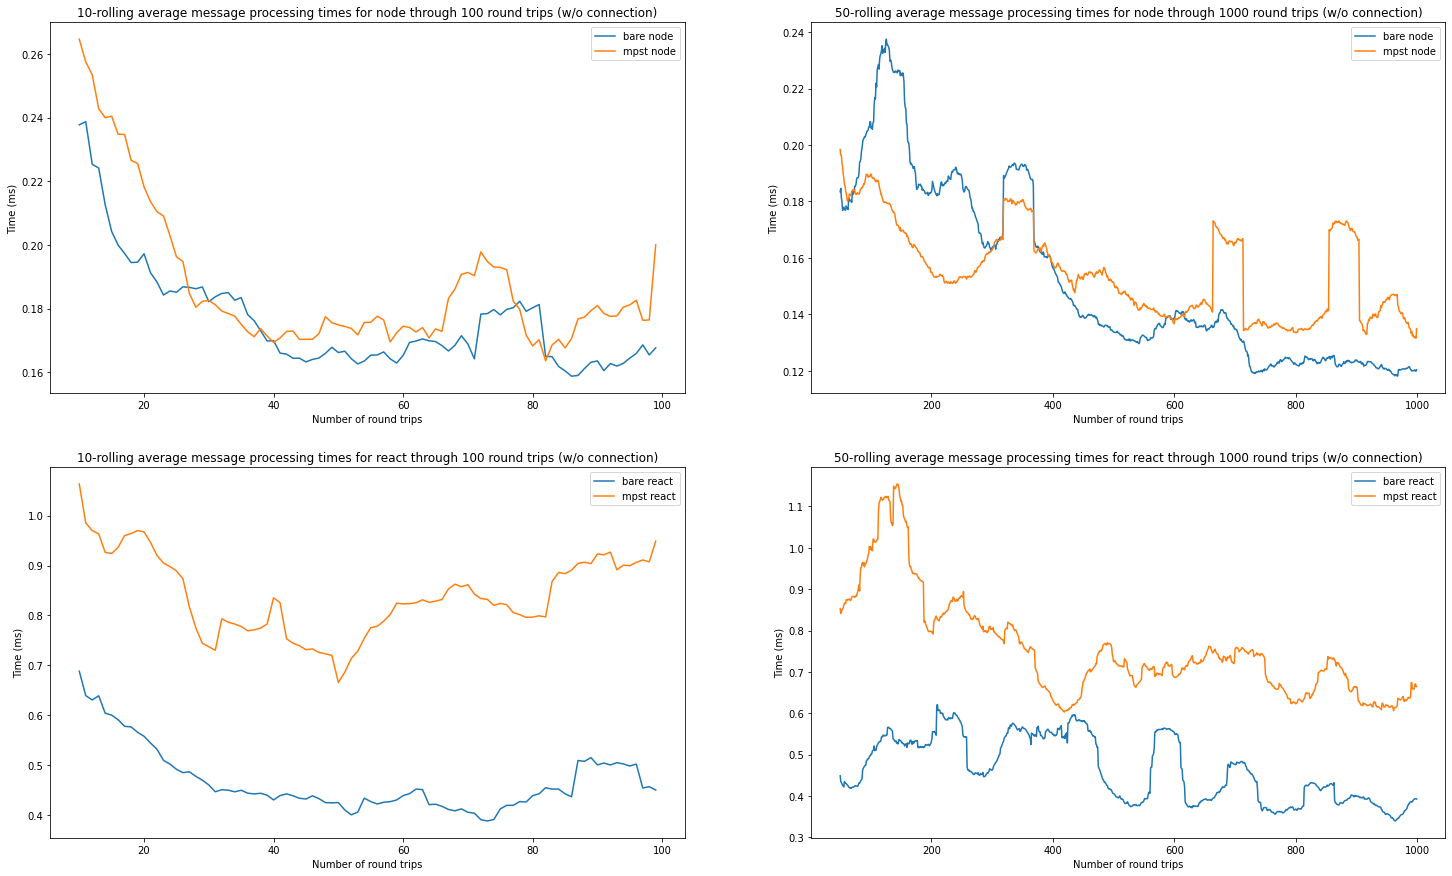

In [20]:
# Same plot, but ignoring the connection phase

fig = plt.figure(figsize=(25, 15))

for i, endpoint in enumerate(ENDPOINTS):
    for j, num_msgs in enumerate(NUM_MSGS):
        idx = i * len(ENDPOINTS) + j + 1
        axs = fig.add_subplot(len(ENDPOINTS), len(NUM_MSGS), idx)
        compare_rolling_avg(library, fig, axs,
                            endpoint=endpoint,
                            num_msgs=num_msgs,
                            interval=rolling_average_interval[num_msgs],
                            ignore_connection=True)

# "Complex" Ping Pong

* PING `<button>` to send ping.
* `<div>` to show number of pongs received.
* Show `ready to ping` text on send state
* Show `all pongs received` text on terminal state

In [21]:
VARIANTS = ('bare', 'mpst')
NUM_MSGS = (100, 1000)
ENDPOINTS = ('node', 'react')

BENCHMARK_PATH = os.path.join(REPO_PATH, 'complex_pingpong')

instances = [accumulate_logs(path=BENCHMARK_PATH,
                             variant=variant,
                             num_msgs=num_msgs)
             for variant in VARIANTS
             for num_msgs in NUM_MSGS]

library = BenchmarkLibrary(instances)

## Compare message processing times between Node and React

Time taken for each round trip is dominated by the message processing logic 
in React.

In [22]:
def plot_react_node_breakdown(library, fig, axs, *, 
                              variant,
                              num_msgs,
                              ignore_connection=False):
    log_instance = library.get(variant=variant, num_msgs=num_msgs)
    node = log_instance.avg_timeline('node')
    react = log_instance.avg_timeline('react')
    
    if ignore_connection:
        node = node[1:]
        react = react[1:]
        time_axis = np.arange(1, num_msgs)
    else:
        time_axis = np.arange(num_msgs)

    axs.stackplot(time_axis, [react, node], labels=['React', 'Node'])
    axs.set_xlabel('Number of round trips')
    axs.set_ylabel('Time (ms)')

    if ignore_connection:
        axs.set_title(f'{variant}: {num_msgs} round trips (w/o connection)')
    else:
        axs.set_title(f'{variant}: {num_msgs} round trips')

    axs.legend(loc='best')

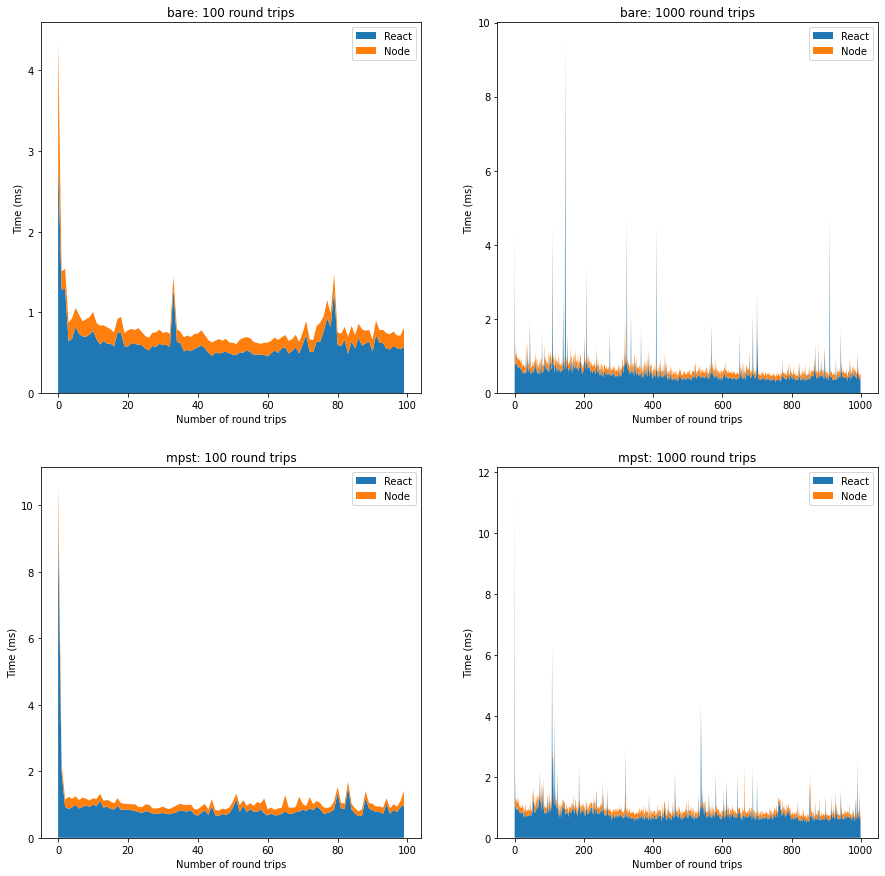

In [23]:
fig = plt.figure(figsize=(15, 15))

for i, variant in enumerate(VARIANTS):
    for j, num_msgs in enumerate(NUM_MSGS):
        idx = i * len(ENDPOINTS) + j + 1
        axs = fig.add_subplot(len(VARIANTS), len(NUM_MSGS), idx)
        plot_react_node_breakdown(library, fig, axs,
                                  variant=variant, num_msgs=num_msgs)

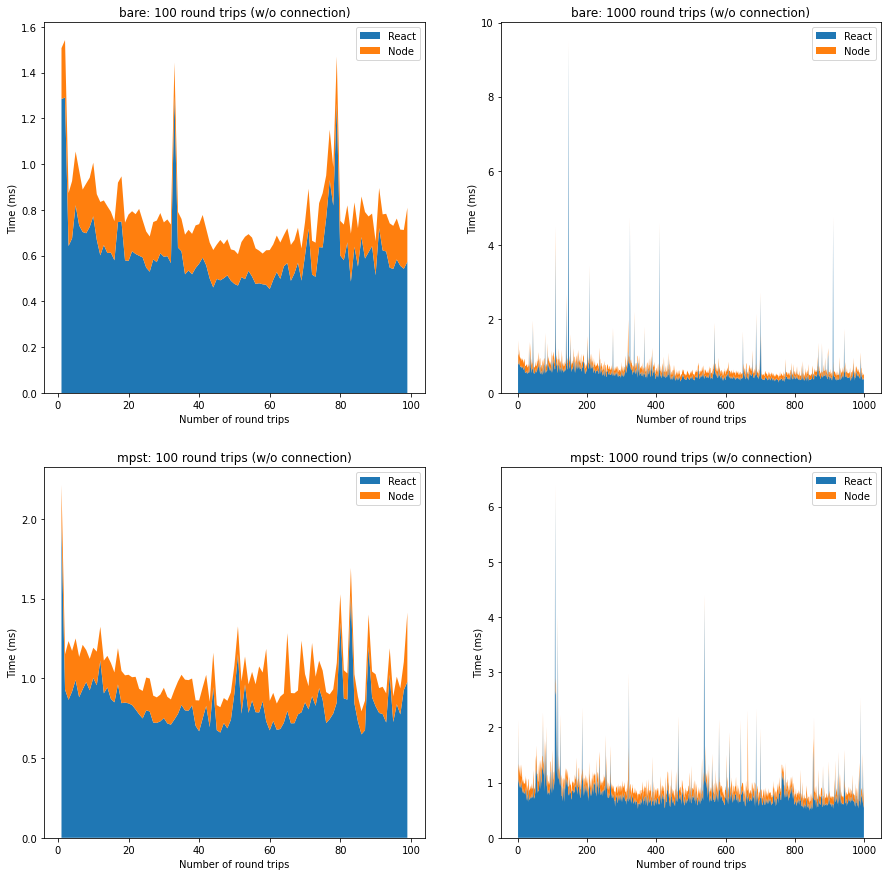

In [24]:
fig = plt.figure(figsize=(15, 15))

for i, variant in enumerate(VARIANTS):
    for j, num_msgs in enumerate(NUM_MSGS):
        idx = i * len(ENDPOINTS) + j + 1
        axs = fig.add_subplot(len(VARIANTS), len(NUM_MSGS), idx)
        plot_react_node_breakdown(library, fig, axs,
                                  variant=variant,
                                  num_msgs=num_msgs,
                                  ignore_connection=True)

## Compare overhead of MPST implementation for each endpoint

Session runtime in React incurs most of the overhead.

In [25]:
def compare_endpoint_log(library, fig, axs, *,
                         endpoint,
                         num_msgs,
                         ignore_connection=False):
    bare = library.get(variant='bare', num_msgs=num_msgs)
    mpst = library.get(variant='mpst', num_msgs=num_msgs)

    bare_times = bare.avg_timeline(endpoint)
    mpst_times = mpst.avg_timeline(endpoint)

    if ignore_connection:
        bare_times = bare_times[1:]
        mpst_times = mpst_times[1:]
        time_axis = np.arange(1, num_msgs)
    else:
        time_axis = np.arange(num_msgs)

    axs.plot(time_axis, bare_times, label=f'bare {endpoint}')
    axs.plot(time_axis, mpst_times, label=f'mpst {endpoint}')

    axs.set_xlabel('Number of round trips')
    axs.set_ylabel('Time (ms)')
    
    if ignore_connection:
        axs.set_title(f'Message processing times for {endpoint} '
                      f'through {num_msgs} round trips (w/o connection)')
    else:
        axs.set_title(f'Message processing times for {endpoint} '
                      f'through {num_msgs} round trips')
    axs.legend(loc='best')

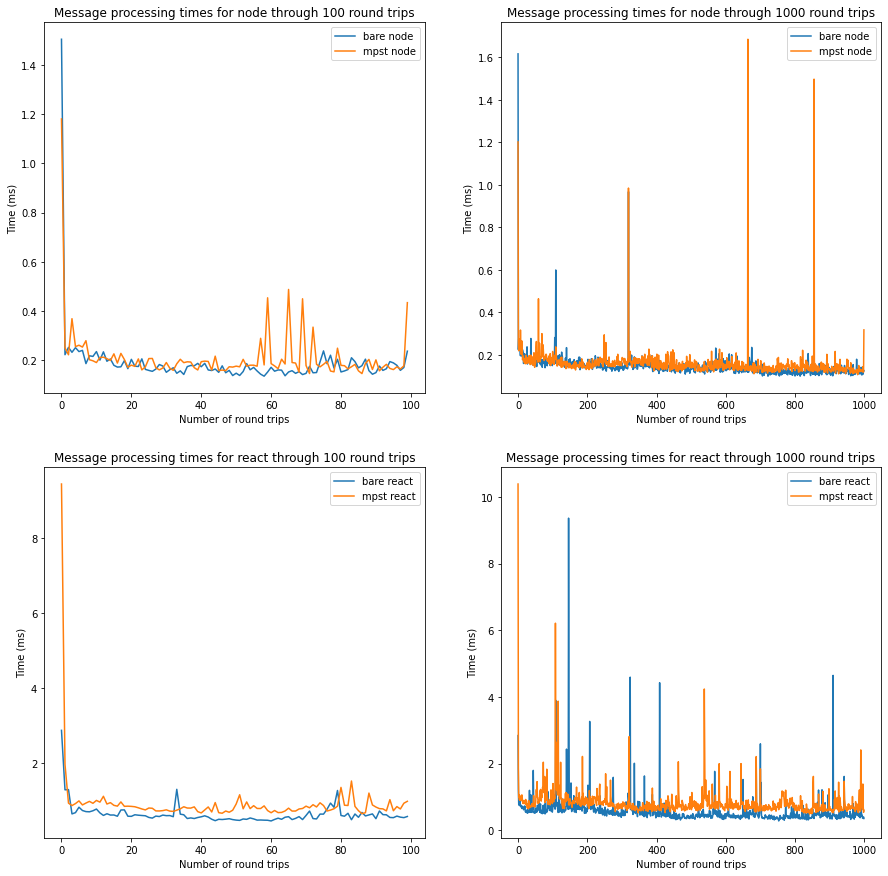

In [26]:
fig = plt.figure(figsize=(15, 15))

for i, endpoint in enumerate(ENDPOINTS):
    for j, num_msgs in enumerate(NUM_MSGS):
        idx = i * len(ENDPOINTS) + j + 1
        axs = fig.add_subplot(len(ENDPOINTS), len(NUM_MSGS), idx)
        compare_endpoint_log(library, fig, axs,
                             endpoint=endpoint,
                             num_msgs=num_msgs)

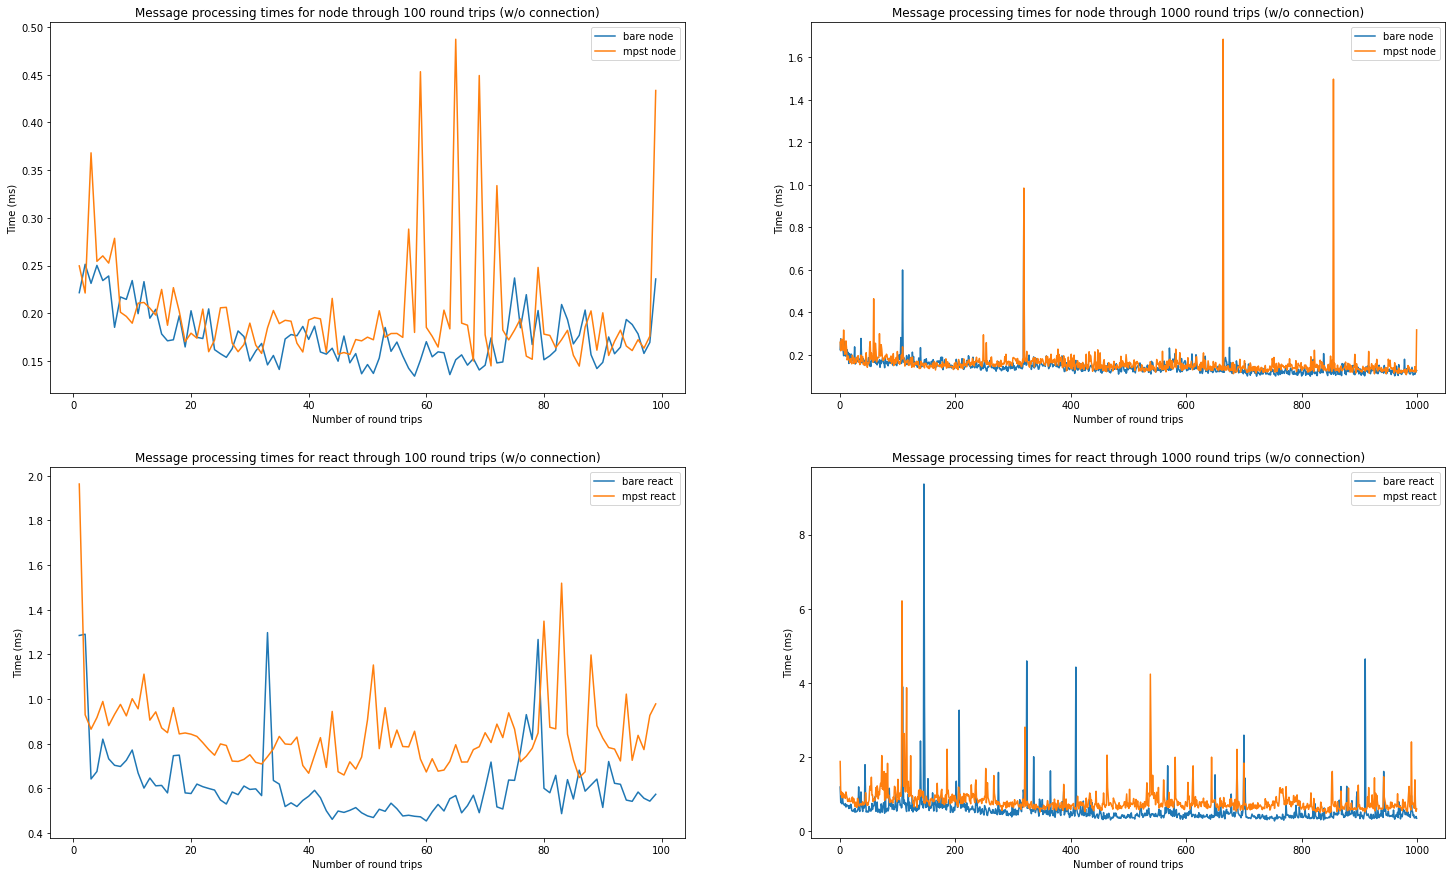

In [27]:
fig = plt.figure(figsize=(25, 15))

for i, endpoint in enumerate(ENDPOINTS):
    for j, num_msgs in enumerate(NUM_MSGS):
        idx = i * len(ENDPOINTS) + j + 1
        axs = fig.add_subplot(len(ENDPOINTS), len(NUM_MSGS), idx)
        compare_endpoint_log(library, fig, axs,
                             endpoint=endpoint,
                             num_msgs=num_msgs,
                             ignore_connection=True)

In [28]:
def compare_average_elapsed(library, *,
                            endpoint,
                            fmt='.7f',
                            ignore_connection=False):
    df = pd.DataFrame(columns=(*VARIANTS, 'delta'),
                      index=NUM_MSGS)
    
    for msg_count in NUM_MSGS:
        bare = library.get(variant='bare', num_msgs=msg_count)
        mpst = library.get(variant='mpst', num_msgs=msg_count)

        if ignore_connection:
            bare_avg = average(bare.avg_timeline(endpoint)[1:])
            mpst_avg = average(mpst.avg_timeline(endpoint)[1:])
        else:
            bare_avg = average(bare.avg_timeline(endpoint))
            mpst_avg = average(mpst.avg_timeline(endpoint))

        avgs = [format(value, fmt)
                for value in (bare_avg, mpst_avg)]
        delta = (mpst_avg - bare_avg) / bare_avg * 100
        
        df.loc[msg_count] = [*avgs, '{:.2f}%'.format(delta)]

    return df

print('Average message processing time for Node')
display(compare_average_elapsed(library, endpoint='node'))
print()

print('Average message processing time for Node (w/o connection)')
display(compare_average_elapsed(library, endpoint='node', ignore_connection=True))
print()

print('Average message processing time for React')
display(compare_average_elapsed(library, endpoint='react'))
print()

print('Average message processing time for React (w/o connection)')
display(compare_average_elapsed(library, endpoint='react', ignore_connection=True))
print()

Average message processing time for Node


,bare,mpst,delta
100,0.1886865,0.2107630,11.70%
1000,0.1456764,0.1594937,9.48%



Average message processing time for Node (w/o connection)


,bare,mpst,delta
100,0.1753864,0.2009621,14.58%
1000,0.1442043,0.1584501,9.88%



Average message processing time for React


,bare,mpst,delta
100,0.6378186,0.9298903,45.79%
1000,0.5766041,0.8259430,43.24%



Average message processing time for React (w/o connection)


,bare,mpst,delta
100,0.6152643,0.8439172,37.16%
1000,0.5743347,0.8163695,42.14%


### Aligning first 100 round trips

In [29]:
def compare_first_100_overlay(library, fig, axs, *,
                              variant,
                              endpoint,
                              ignore_connection=False):
    logs_100 = library.get(variant=variant, num_msgs=100)
    logs_1000 = library.get(variant=variant, num_msgs=1000)

    times_100 = logs_100.avg_timeline(endpoint)
    times_1000 = logs_1000.avg_timeline(endpoint)

    if ignore_connection:
        times_100 = times_100[1:]
        times_1000 = times_1000[1:100]
        time_axis = np.arange(1, 100)
    else:
        times_1000 = times_1000[:100]
        time_axis = np.arange(100)
    
    axs.plot(time_axis, times_100, label=f'{variant} {endpoint} (100)')
    axs.plot(time_axis, times_1000, label=f'{variant} {endpoint} (1000)')

    axs.set_xlabel('Number of round trips')
    axs.set_ylabel('Time (ms)')

    if ignore_connection:
        axs.set_title(f'Message processing times for {variant}_{endpoint} '
                      f'through 100 round trips (w/o connection)')
    else:
        axs.set_title(f'Message processing times for {variant}_{endpoint} '
                      f'through 100 round trips')

    axs.legend(loc='best')

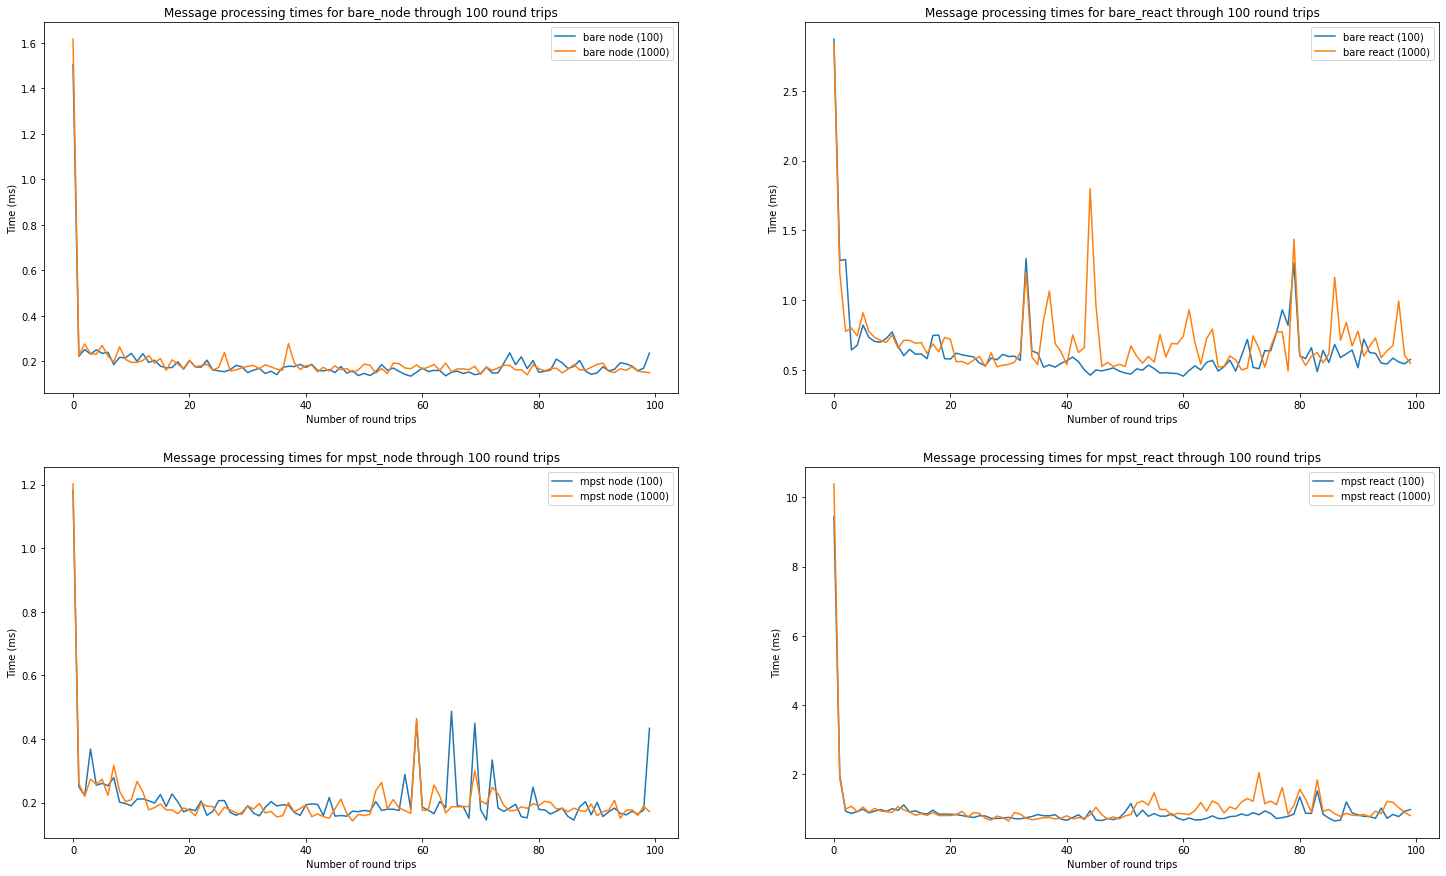

In [30]:
fig = plt.figure(figsize=(25, 15))

for i, variant in enumerate(VARIANTS):
    for j, endpoint in enumerate(ENDPOINTS):
        idx = i * len(ENDPOINTS) + j + 1
        axs = fig.add_subplot(len(VARIANTS), len(ENDPOINTS), idx)
        compare_first_100_overlay(library, fig, axs,
                                  variant=variant,
                                  endpoint=endpoint)

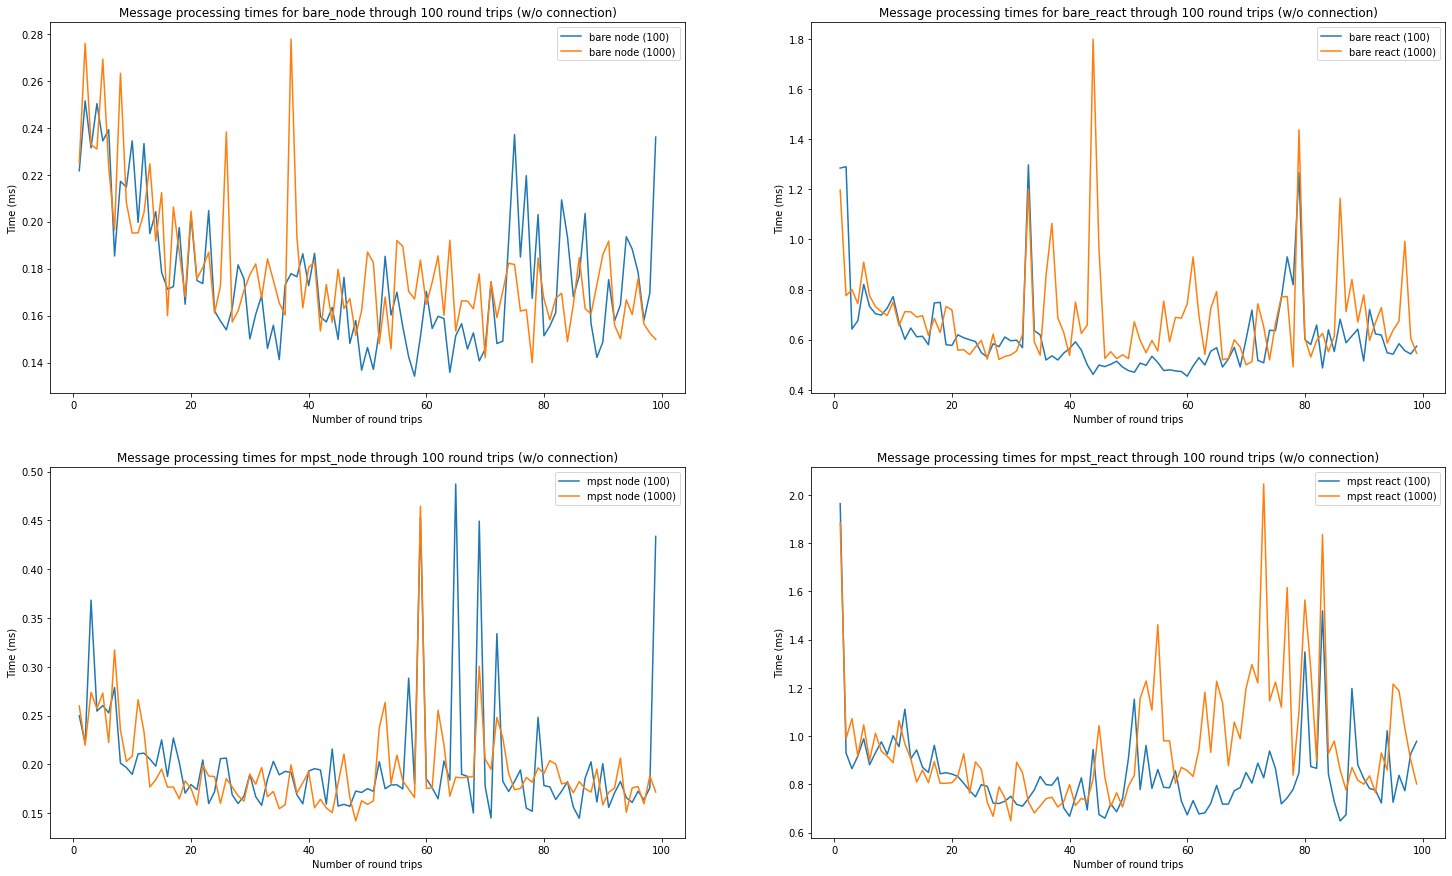

In [31]:
# Same plots, but ignoring the connection phase

fig = plt.figure(figsize=(25, 15))

for i, variant in enumerate(VARIANTS):
    for j, endpoint in enumerate(ENDPOINTS):
        idx = i * len(ENDPOINTS) + j + 1
        axs = fig.add_subplot(len(VARIANTS), len(ENDPOINTS), idx)
        compare_first_100_overlay(library, fig, axs,
                                  variant=variant,
                                  endpoint=endpoint,
                                  ignore_connection=True)

### Comparing Rollng Averages

In [32]:
def compare_rolling_avg(library, fig, axs, *,
                        endpoint,
                        num_msgs,
                        ignore_connection=False,
                        interval=10):
    bare = library.get(variant='bare', num_msgs=num_msgs)
    mpst = library.get(variant='mpst', num_msgs=num_msgs)

    bare_times = bare.avg_timeline(endpoint)
    mpst_times = mpst.avg_timeline(endpoint)

    if ignore_connection:
        bare_times = bare_times[1:]
        mpst_times = mpst_times[1:]
        time_axis = np.arange(1, num_msgs)
    else:
        time_axis = np.arange(num_msgs)

    axs.plot(time_axis, rolling_average(bare_times, interval),
             label=f'bare {endpoint}')
    axs.plot(time_axis, rolling_average(mpst_times, interval),
             label=f'mpst {endpoint}')

    axs.set_xlabel('Number of round trips')
    axs.set_ylabel('Time (ms)')
    
    if ignore_connection:
        axs.set_title(f'{interval}-rolling average message processing times '
                      f'for {endpoint} through {num_msgs} '
                      f'round trips (w/o connection)')
    else:
        axs.set_title(f'{interval}-rolling average message processing times '
                      f'for {endpoint} through {num_msgs} round trips')

    axs.legend(loc='best')

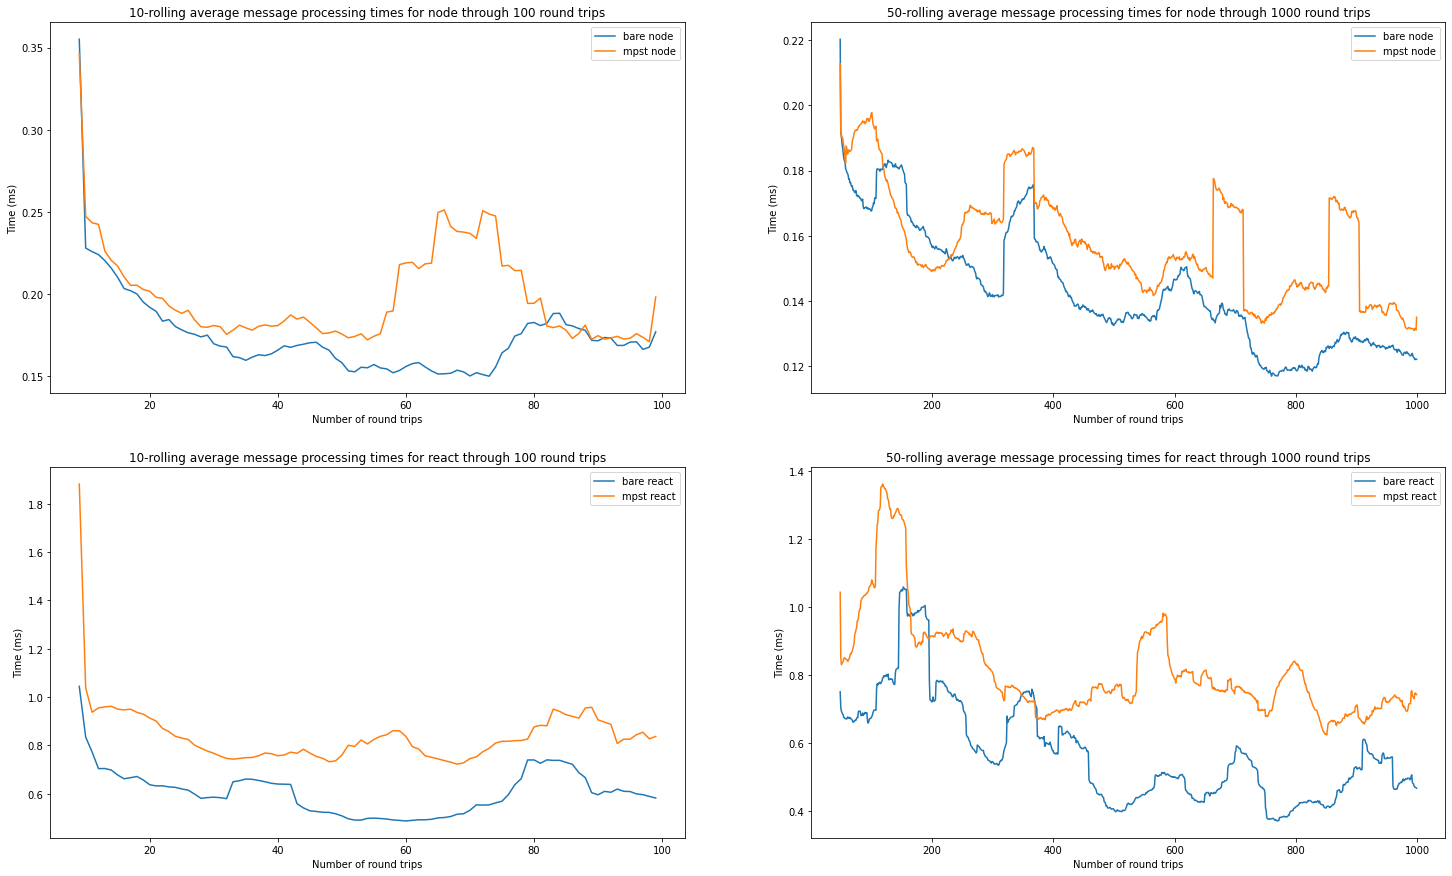

In [33]:
fig = plt.figure(figsize=(25, 15))
rolling_average_interval = {100: 10, 1000: 50}

for i, endpoint in enumerate(ENDPOINTS):
    for j, num_msgs in enumerate(NUM_MSGS):
        idx = i * len(ENDPOINTS) + j + 1
        axs = fig.add_subplot(len(ENDPOINTS), len(NUM_MSGS), idx)
        compare_rolling_avg(library, fig, axs,
                            endpoint=endpoint,
                            num_msgs=num_msgs,
                            interval=rolling_average_interval[num_msgs])

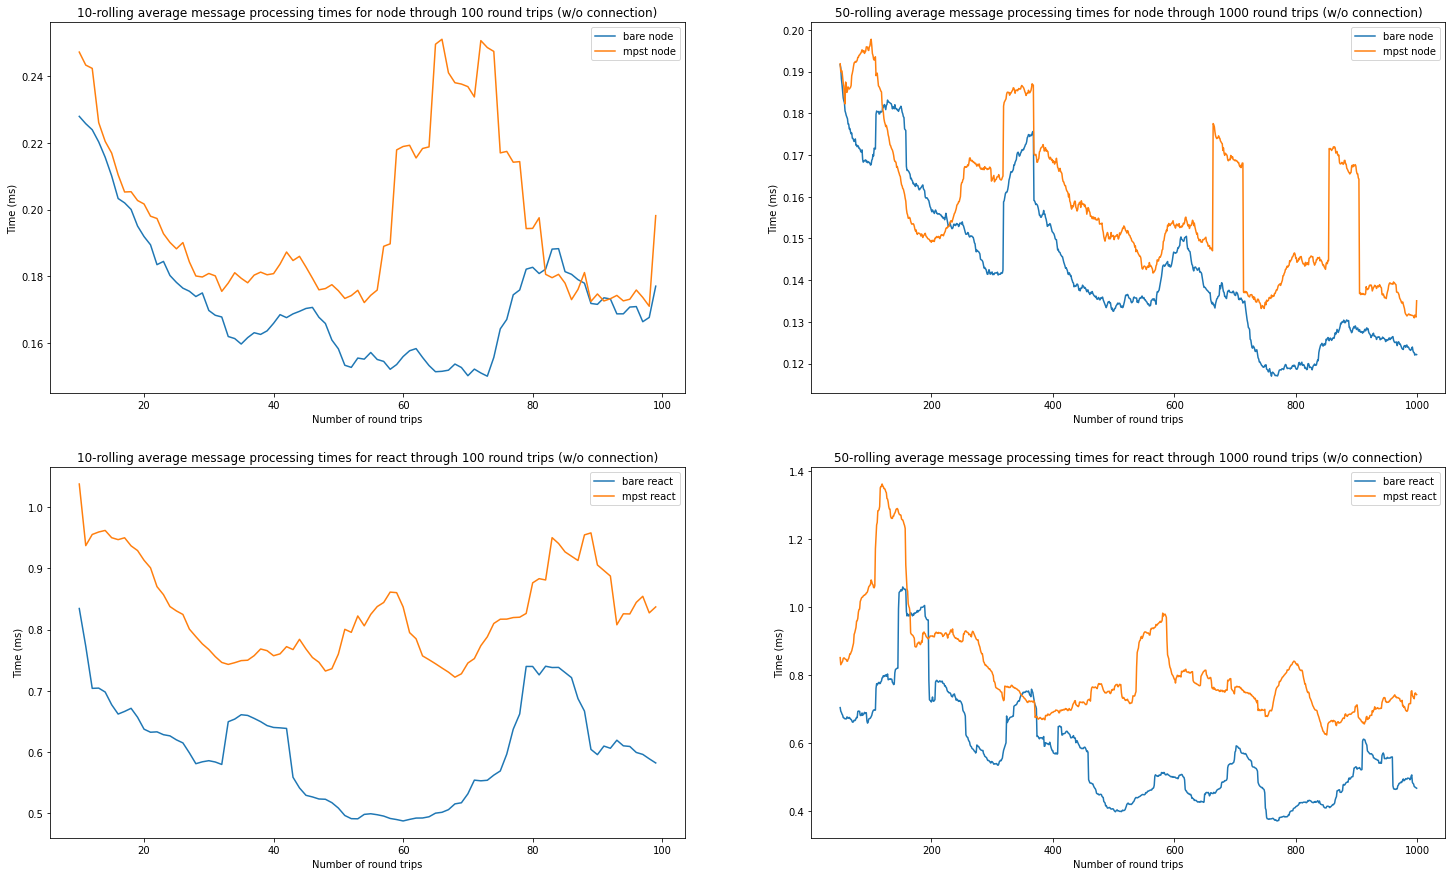

In [34]:
# Same plot, but ignoring the connection phase

fig = plt.figure(figsize=(25, 15))

for i, endpoint in enumerate(ENDPOINTS):
    for j, num_msgs in enumerate(NUM_MSGS):
        idx = i * len(ENDPOINTS) + j + 1
        axs = fig.add_subplot(len(ENDPOINTS), len(NUM_MSGS), idx)
        compare_rolling_avg(library, fig, axs,
                            endpoint=endpoint,
                            num_msgs=num_msgs,
                            interval=rolling_average_interval[num_msgs],
                            ignore_connection=True)